In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
%matplotlib inline

/home/sergio/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/home/sergio/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




In [2]:
master = pd.read_csv('data/Master.csv', parse_dates=['debut', 'finalGame'])
# Currently not caring about pitchers

In [3]:
bbmaster = master[['playerID', 'nameFirst', 'nameLast', 'nameGiven']]

In [4]:
batting = pd.read_csv('data/Batting.csv')

In [5]:
batting['TB'] = batting['H'] + 2 * batting['2B'] + 3 * batting['3B'] + 4 * batting['HR']
batting['SLG'] = batting['TB'] / batting['AB']

In [6]:
master_batting = pd.merge(master, batting)

In [7]:
bats = batting[['playerID', 'yearID','AB', 'H', 'BB', 'HBP', 'SF']]
bbdata2 = pd.merge(bbmaster, master_batting)

In [8]:
salaries = pd.read_csv('data/Salaries.csv')

In [9]:
salaries = salaries[['yearID', 'playerID', 'salary']]

In [10]:
bbdata_sal = pd.merge(bbdata2, salaries)

In [11]:
# Drop all AB values of 0 or null (average at-bats in MLB is 30/year)
bbdata_sal = bbdata_sal.drop(bbdata_sal.index[(bbdata_sal['AB'] < 15) | \
                                              (bbdata_sal['H']  < 1) | \
                                              (pd.isnull(bbdata_sal['AB']))])

In [12]:
bbdata_sal['OBP'] = bbdata_sal.apply(lambda row: (row['H'] + row['BB'] + row['HBP']) * 100 / \
                                     (row['AB'] + row['BB'] + row['HBP'] + row['SF']), axis=1)

In [13]:
bbdata_sal.sort_values(by=['OBP'], ascending=False).head(2)

,playerID,nameFirst,nameLast,nameGiven,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,...,SO,IBB,HBP,SH,SF,GIDP,TB,SLG,salary,OBP
2518,bondsba01,Barry,Bonds,Barry Lamar,1964.0,7.0,24.0,USA,CA,Riverside,...,41.0,120.0,9.0,0.0,3.0,5.0,378,1.013405,18000000,60.940032
2516,bondsba01,Barry,Bonds,Barry Lamar,1964.0,7.0,24.0,USA,CA,Riverside,...,47.0,68.0,9.0,0.0,2.0,4.0,401,0.995037,15000000,58.169935


In [14]:
bbdata_sal = bbdata_sal.drop(bbdata_sal.index[bbdata_sal['salary'] <= 0])
pass

In [15]:
bbdata_sal['OBP_sal_10k'] = bbdata_sal.apply(lambda row: row['OBP'] * 10000 / row['salary'], axis=1)
bbdata_sal.sort_values(by=['OBP_sal_10k'], ascending=False).head(2)

,playerID,nameFirst,nameLast,nameGiven,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,...,IBB,HBP,SH,SF,GIDP,TB,SLG,salary,OBP,OBP_sal_10k
23508,silveda01,Dave,Silvestri,David Joseph,1967.0,9.0,29.0,USA,MO,St. Louis,...,0.0,0.0,0.0,0.0,1.0,12,0.571429,10900,42.307692,38.814397
8849,gibbojo02,John,Gibbons,John Michael,1962.0,6.0,8.0,USA,MT,Great Falls,...,1.0,0.0,0.0,0.0,1.0,21,1.105263,65000,54.545455,8.391608


In [16]:
appearances = pd.read_csv('data/Appearances.csv')

In [17]:
appearances.pop('lgID')
appearances.pop('teamID')
pass

In [18]:
mb_data = pd.merge(appearances, bbdata_sal)

In [19]:
mb_data['OPS'] = round(mb_data['OBP'] + mb_data['SLG'], 5)
mb_data['PQ'] = round(mb_data['OPS'] / mb_data['salary'], 10)

In [20]:
def fromYear(data, year):
    values = data[['yearID', 'nameLast', 'salary', 'OPS', 'PQ']].sort_values(by = ['PQ'], ascending=False)
    return values[values['yearID'] == year]

In [47]:
data = fromYear(mb_data, 2002).drop_duplicates()

In [48]:
data.sample(50).to_csv('results.csv', index = False)
sample = data.sample(30).sort_values(by = ['PQ'], ascending=False)

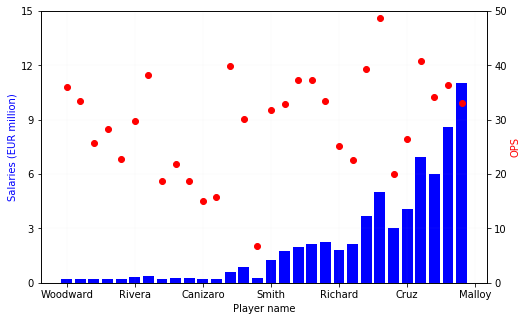

In [120]:
# Axis for the tokens
x_axis = np.arange(len(sample['nameLast']))
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Player name', color='k')
ax.set_ylabel('Salaries (EUR million)', color='b')
ax.grid(linewidth=0.05)
ax.set_xticklabels(sample['nameLast'])
ax.set_ylim(0, 15)
ax.set_yticks([0, 3, 6, 9, 12, 15])
ax.bar(x_axis, sample['salary'] / 10**6, color='b')

# Axis for the forwarded bytes
ax2 = ax.twinx()                
ax2.set_ylabel('OPS', color='r')
#ax2.bar(x_axis, sample['salary'])
ax2.plot(x_axis, sample['OPS'], 'o', lw=3, color='r')
ax2.set_ylim(0, 50)
ax2.set_yticks([0, 10, 20, 30, 40, 50])


# Plot

#plt.tight_layout()
plt.savefig('comparison.pdf', format='pdf', dpi=300)

# Cost per win

In [54]:
ald_teams = ['SFN', 'ANA', 'SLN', 'OAK', 'ATL', 'ARI', 'MIN', 'NYA']
year = 2002

In [55]:
teams = pd.read_csv('data/Teams.csv')[['yearID', 'name', 'teamID', 'W']]
teams_2002 = teams[(teams['yearID'] == year) & (teams['teamID'].isin(ald_teams))]
# teams_2002

In [56]:
appearances = pd.read_csv('data/Appearances.csv')[['yearID', 'teamID', 'playerID', 'G_all']]
appearances_2002 = appearances[appearances['yearID'] == year].drop(axis=1, labels='yearID')
teams_appearances_2002 = pd.merge(teams_2002, appearances_2002, on='teamID')
# teams_appearances_2002
#print(teams_appearances_2002[teams_appearances_2002['name'] == 'Toronto Blue Jays'])

In [57]:
salaries = pd.read_csv('data/Salaries.csv')[['playerID', 'yearID', 'salary']]
salaries_2002 = salaries[salaries['yearID'] == year].drop(axis=1, labels='yearID')
print(len(salaries_2002))
teams_appearances_salaries_2002 = pd.merge(teams_appearances_2002, salaries_2002, on = 'playerID')

# teams_appearances_salaries_2002.sort_values(by=['name'])

846


In [69]:
data_2 = teams_appearances_salaries_2002.drop(axis=1, labels=['yearID', 'G_all', 'playerID'])
# data

In [70]:
cost = pd.DataFrame({'cost':(data_2.groupby('name').sum()['salary'] / data_2.groupby('name').mean()['W']) / 10**6}).reset_index()

In [123]:
cost_per_win = data_2.drop(axis=1, labels=['salary']).drop_duplicates().reset_index()
result = pd.merge(cost_per_win, cost, on='name').sort_values(by='cost')

#result
result[['teamID', 'name', 'W']]

,teamID,name,W
3,MIN,Minnesota Twins,94
5,OAK,Oakland Athletics,103
0,ANA,Anaheim Angels,99
6,SFN,San Francisco Giants,95
2,ATL,Atlanta Braves,101
7,SLN,St. Louis Cardinals,97
1,ARI,Arizona Diamondbacks,98
4,NYA,New York Yankees,103


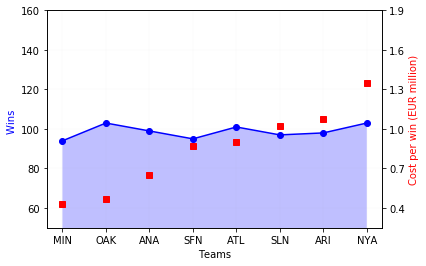

In [113]:
# Axis for the tokens
x_axis = np.arange(len(result['name']))
fig = plt.figure()
# plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Teams', color='k')
ax.set_ylabel('Wins ', color='b')
ax.grid(linewidth=0.05)
ax.set_ylim(50, 160)
ax.set_xticks(x_axis)
ax.set_xticklabels(result['teamID'])
ax.plot(x_axis, result['W'], '-o', color='b')
ax.fill_between(x_axis, 0, result['W'], facecolor='blue', alpha=0.25)


# Axis for the forwarded bytes
ax2 = ax.twinx()                
ax2.set_ylabel('Cost per win (EUR million)', color='r')
ax2.plot(x_axis, result['cost'], 's', lw=3, color='r')
ax2.set_ylim(0.25, 1.8)
ax2.set_yticks([0.4, 0.7, 1.0, 1.3, 1.6, 1.9])


# Plot

# plt.tight_layout()
plt.savefig('cost_per_win.pdf', format='pdf', dpi=300)